# Acne Classification using VGG16

Using an augmented dataset of 8000 images, from 2000 faces with acne (400 images each class: healthy, mild, moderate and severe) a model is trained to classify acne into one of this four categories. Using a learning rate of $1 x 10^{-4}$ over $10$ epochs

In [4]:
import numpy as np
#NumPy, which stands for Numerical Python, is a library consisting of multidimensional array objects 
#and a collection of routines for processing those arrays. Using NumPy, mathematical and logical operations on arrays 
#can be performed. NumPy is a Python package.

import os

import time
# “time” which allows us to handle various operations regarding time, its conversions and representations

from vgg16 import VGG16
#import function VGG16 from the module (.py) vgg16

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.utils import np_utils
#import the necessary functions from the keras library

from sklearn.utils import shuffle
#shuffle. Shuffle arrays or sparse matrices in a consistent way. 
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
from sklearn.model_selection import train_test_split
#train_test_split is a function in Sklearn model selection for splitting data arrays into two subsets: 
#for training data and for testing data.

In [5]:
num_classes = 4
IMAGES_DIRECTORY = "imagesdata2/data"

# Make the images directory if it does not exist
if not os.path.exists(IMAGES_DIRECTORY):
    os.mkdir(IMAGES_DIRECTORY)
    
    # Take the ten folders with the most images and move to new directory
    # Rename the folders with the number of images and name of individual
    for person in people_number[:num_classes]:
        name = person[0]
        # Original download directory path
        folder_path = IMAGES_DOWNLOAD_DIRECTORY + '/lfw-deepfunneled/' + name
        formatted_num_images = str(person[1]).zfill(3)
        new_folder_name = "{} {}".format(formatted_num_images, name)
        image_new_name = IMAGES_DIRECTORY + "/" + new_folder_name
        
        # Make a new folder for each individual in the images directory
        os.mkdir(IMAGES_DIRECTORY + '/' + name)
        # Copy the folder from the download location to the new folder
        copy_tree(folder_path, IMAGES_DIRECTORY + '/' + name)
        # Rename the folder with images and individual
        os.rename(IMAGES_DIRECTORY + '/' + name, image_new_name)

In [6]:
os.listdir("imagesdata2/data") 

['2000 Healthy', '2000 Mild Acne', '2000 Moderate Acne', '2000 Severe Acne']

In [7]:
#Map each class to an integer label
class_mapping = {}
class_images1 = {}

# Create dictionary to map integer labels to individuals
# Class_images will record number of images for each class
for index, directory in enumerate(os.listdir("imagesdata2/data/")):
    class_mapping[index] = directory.split(" ")[1]
    class_images1[index] = int(directory.split(' ')[0])

In [8]:
class_mapping

{0: 'Healthy', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}

In [9]:
class_images1

{0: 2000, 1: 2000, 2: 2000, 3: 2000}

In [10]:
#We can look at the distribution of each class.
total_num_images = np.sum(list(class_images1.values()))

print("Acne Severity Training \t Composition of Dataset\n")
for label, num_images in class_images1.items():
    print("{:20} {:.2f}%".format(
        class_mapping[label], (num_images / total_num_images) * 100))

Acne Severity Training 	 Composition of Dataset

Healthy              25.00%
Mild                 25.00%
Moderate             25.00%
Severe               25.00%


In [11]:
#Read the images into RGB (red-green-blue) pixel value arrays.
import matplotlib.pyplot as plt
import cv2
#Matplotlib is a Python library that helps to plot graphs. It is used in data visualization and graphical plotting.


image_arrays = []
image_labels = []
root_image_directory = "imagesdata2/data/"
target_height=224;
target_width=224;

for label, person in class_mapping.items():
    for directory in os.listdir(root_image_directory):
        if directory.split(" ")[1] == person:
            image_directory = root_image_directory + directory
            break
            
    for image in os.listdir(image_directory):
        image = plt.imread(os.path.join(image_directory, image))
        image = cv2.resize(image, (target_width, target_height))
        image_arrays.append(image)
        image_labels.append(label)

In [12]:
image_arrays = np.array(image_arrays)
image_labels = np.array(image_labels)
print(image_arrays.shape, image_labels.shape)

(8000, 224, 224, 3) (8000,)


In [13]:
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(image_labels, num_classes)
print('Example After conversion to one-hot:', Y[0])

Example After conversion to one-hot: [1. 0. 0. 0.]


In [14]:
#Shuffle the dataset
x,y = shuffle(image_arrays,Y, random_state=2)

In [15]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6400, 224, 224, 3) (1600, 224, 224, 3)
(6400, 4) (1600, 4)


In [16]:
#########################################################################################
# Custom_vgg_model_1
#Training the classifier alone
image_input = Input(shape=(224, 224, 3))
model1 = VGG16(weights='imagenet',include_top=False,input_tensor=image_input)
model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from keras.layers import Dropout
from keras.layers.pooling import GlobalAveragePooling2D
#import the necessary functions from the keras library

x = model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(inputs=model1.input, outputs=predictions)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
for i, layer in enumerate(model1.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [19]:
# Make the conv_base NOT trainable:

for layer in model1.layers[:]:
    layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [20]:
# Make last block of the conv_base trainable:

for layer in model1.layers[:15]:
    layer.trainable = False
for layer in model1.layers[15:]:
    layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [21]:
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [23]:
from keras.optimizers import SGD
from keras.optimizers import Adam

opt = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"])
#opt = SGD(lr=1e-4, momentum=0.9)
#model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logss")

In [27]:
t=time.time()
hist = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[tensorboard])

(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
400/400 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7350WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000234CB3C7798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

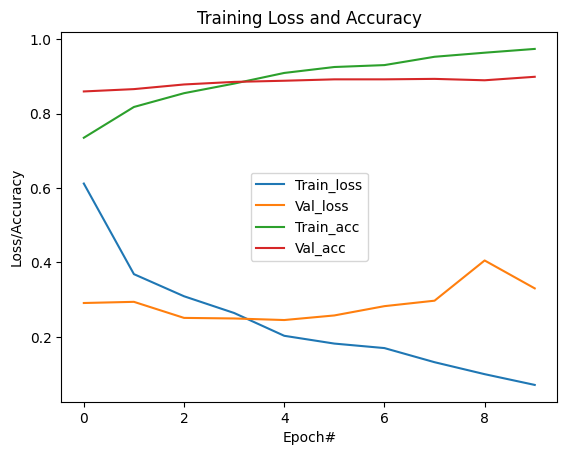

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(0, 10), hist.history["loss"], label= "Train_loss")
plt.plot(np.arange(0, 10), hist.history["val_loss"], label= "Val_loss")
plt.plot(np.arange(0, 10), hist.history["accuracy"], label= "Train_acc")
plt.plot(np.arange(0, 10), hist.history["val_accuracy"], label= "Val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [29]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(50)
epochs = range(len(train_acc))

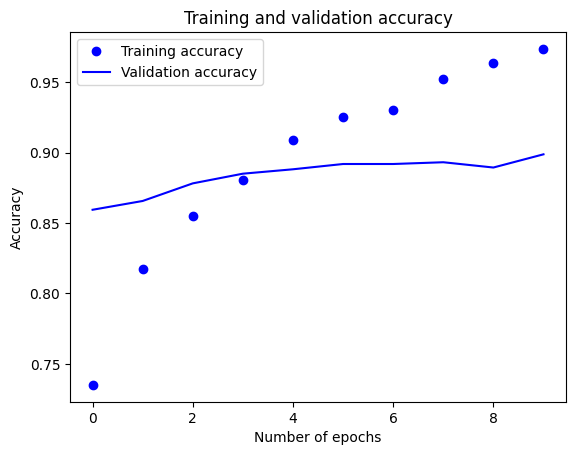

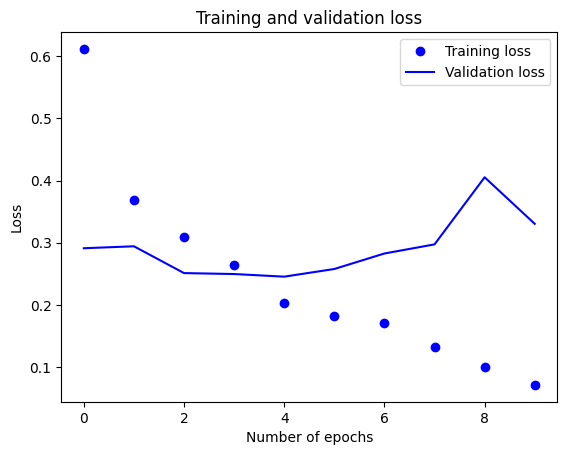

In [30]:
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss , 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
from keras.models import Sequential
from keras.layers import Dense
import json
from keras.models import model_from_json, load_model


# serialize model to JSON
model_json = model.to_json()
with open("acne_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("acne_model.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
# load json and create model
json_file = open('acne_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("acne_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [33]:
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import confusion_matrix.
#confusion_matrix(y_train_5, y_train_pred) 
#Each row in a confusion matrix represents an actual class, while each column represents a predicted class.
import keras

preds=loaded_model.predict(np.array(X_test))
predicted_classes = np.argmax(np.round(preds),axis=1)
predicted_classes1 = np.array(predicted_classes)
y_pred=predicted_classes1
testy = np.argmax(np.round(y_test),axis=1)
ytrue = np.array(testy)

print(y_pred)
print(ytrue)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - 424s 8s/step
[2 0 3 ... 2 3 2]
[2 0 3 ... 2 3 2]


Confusion matrix, without normalization
Normalized confusion matrix


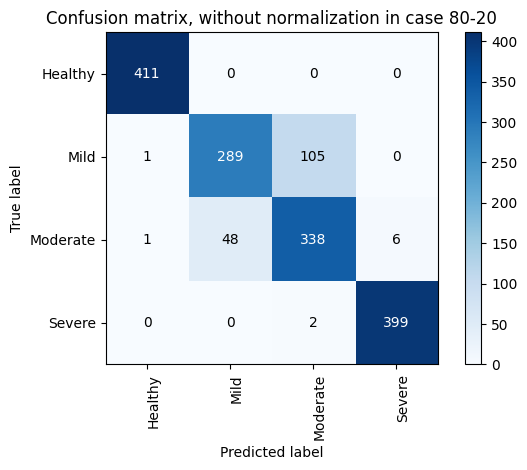

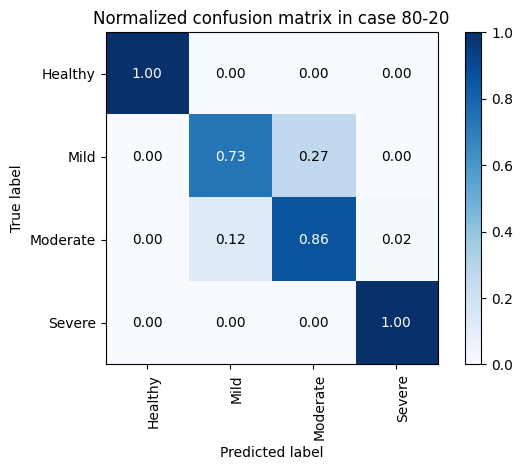

In [35]:
classes=['Healthy','Mild','Moderate','Severe']

def plot_confusion_matrix(ytrue, y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(ytrue, y_pred)
    # Only use the labels that appear in the data
    
    classes=['Healthy','Mild','Moderate','Severe']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(ytrue, y_pred, classes=classes,
                      title='Confusion matrix, without normalization in case 80-20')

# Plot normalized confusion matrix
plot_confusion_matrix(ytrue, y_pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix in case 80-20')

plt.show()

In [36]:
import pandas as pd
#pandas (all lowercase) is a popular Python-based data analysis toolkit which can be imported using import pandas as pd .
from sklearn.metrics import classification_report
#A Classification report is used to measure the quality of predictions from a classification algorithm. ... 
#The report shows the main classification metrics precision, recall and f1-score on a per-class basis. 
#The metrics are calculated by using true and false positives, true and false negatives.

y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
target_names=['Healthy','Mild','Moderate','Severe']
print(classification_report(y_actu, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       411
        Mild       0.86      0.73      0.79       395
    Moderate       0.76      0.86      0.81       393
      Severe       0.99      1.00      0.99       401

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600



In [37]:
correct = np.where(y_pred==y_actu)[0]
print ("Found %d correct labels" % len(correct))
incorrect = np.where(y_pred!=y_actu)[0]
print ("Found %d incorrect labels" % len(incorrect))

Found 1437 correct labels
Found 163 incorrect labels


In [38]:
model.save('acne_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

INFO:tensorflow:Assets written to: acne_model\assets


INFO:tensorflow:Assets written to: acne_model\assets
